In [34]:
import numpy as np
import networkx as nx
import random
import copy
import time
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [35]:
def set_edge_weight(g):
    a=nx.adjacency_matrix(g).todense()
    a=np.array(a+np.eye(cur_n))
    b=np.random.rand(cur_n,cur_n)
    c=a*b
    edge_weight = normalize(c, axis=0, norm='l1')
    return edge_weight


In [36]:
def preprocess(g):
    seed=random.sample(g.nodes(),round(cur_n*seed_perc))
    if type(g) == nx.MultiGraph or type(g) == nx.MultiDiGraph:
        raise Exception( \
          "linear_threshold() is not defined for graphs with multiedges.")
    for s in seed:
        if s not in g.nodes():
            raise Exception("seed", s, "is not in graph")

    # change to directed graph
    if not g.is_directed():
        DG = g.to_directed()
    else:
        DG = copy.deepcopy(g)        # copy.deepcopy 深拷贝 拷贝对象及其子对象

    # init thresholds
    for n in DG.nodes():
        if 'threshold' not in DG.node[n]:
            DG.node[n]['threshold'] = random.random()
        elif DG.node[n]['threshold'] > 1:
            raise Exception("node threshold:", DG.node[n]['threshold'], \
                            "cannot be larger than 1")

    edge_weight = set_edge_weight(DG)

    # init influence weight
    for e in DG.edges():
        if 'influence' not in DG[e[0]][e[1]]:
            DG[e[0]][e[1]]['influence'] =  edge_weight[e[0]][e[1]]   #设置边的权重
        elif DG[e[0]][e[1]]['influence'] > 1:
            raise Exception("edge influence:", DG[e[0]][e[1]]['influence'], \
                            "cannot be larger than 1")
    return DG,seed

In [37]:
def _influence_sum(G, froms, to):
  influence_sum = 0.0
  for f in froms:
    influence_sum += G[f][to]['influence']
  return influence_sum

In [38]:
def _diffuse_one_round(G, A):
  activated_nodes_of_this_round = set()
  for s in A:
    nbs = G.successors(s)
    for nb in nbs:
      if nb in A:
        continue
      active_nb = list(set(G.predecessors(nb)).intersection(set(A)))
      if _influence_sum(G, active_nb, nb) >= G.node[nb]['threshold']:
        activated_nodes_of_this_round.add(nb)
  A.extend(list(activated_nodes_of_this_round))
  return A, list(activated_nodes_of_this_round)

In [39]:
def _diffuse_all(g, A):
  layer_i_nodes = [ ]
  layer_i_nodes.append([i for i in A])
  while True:
    len_old = len(A)
    A, activated_nodes_of_this_round = _diffuse_one_round(g, A)
    layer_i_nodes.append(activated_nodes_of_this_round)
    if len(A) == len_old:
      break
  return layer_i_nodes

In [40]:
def accurate_influence(g,seed):
    # perform diffusion
    A = copy.deepcopy(seed)
    result=_diffuse_all(g, A)
    result_flat = [item for sublist in result for item in sublist]
    return len(result_flat),len(result_flat)/len(g.nodes())






In [41]:
def live_edge(g,seed,iter):
    covered_list=[]
    for t in range(iter): 
        # live-edge sample
        live_edge_sample = nx.DiGraph()
        for v in g.nodes():
            u_list = list(g.predecessors(v))
            weights=[g[u][v]['influence'] for u in u_list]
            u_list.append(v)
            weights.append(1-sum(weights))
            u_select=np.random.choice(u_list, p=weights)
            if v!=u_select:
                live_edge_sample.add_edge(u_select,v)
    
        covered = set()
        for s in seed:
            if s in live_edge_sample.nodes():
                _coverd_by_a_seed=set(nx.bfs_tree(live_edge_sample,s))
                covered=covered.union(_coverd_by_a_seed,covered)
        covered_list.append(len(covered))
    coverd_mean=sum(covered_list)/len(covered_list)
    return coverd_mean,coverd_mean/len(g.nodes())

In [42]:
influence_auc_pct_list=[]
influence_le_pct_list=[]
auc_time_list=[]
le_time_list=[]

for _ in range(100):
    max_n = 500
    min_n = 300
    seed_perc = 0.1
    le_iter=10
    cur_n = np.random.randint(max_n - min_n + 1) + min_n
    g_synthesis = nx.barabasi_albert_graph(n=cur_n, m=4)
    DG,seed=preprocess(g_synthesis)
    time_1=time.time()
    influence_auc,influence_auc_pct=accurate_influence(DG,seed)
    time_2=time.time()
    influence_le,influence_le_pct=live_edge(DG,seed,le_iter)
    time_3=time.time()
    auc_time_list.append(time_2-time_1)
    le_time_list.append(time_3-time_2)
    
    
    # print(
    #     "网络规模为:{} 精确遍历拓展度为：{},{},活跃边图拓展度为:{},{}".format(
    #     len(DG.nodes()),
    #     influence_auc,
    #     influence_auc_pct,
    #     influence_le,
    #     influence_le_pct
    #     )
    # )
    influence_auc_pct_list.append(influence_auc_pct)
    influence_le_pct_list.append(influence_le_pct)

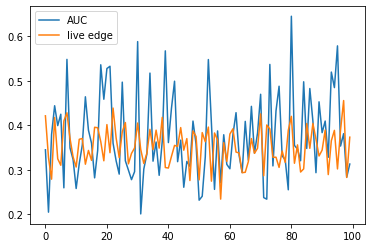

In [43]:
plt.figure()
plt.plot(influence_auc_pct_list,'-',label='AUC')
plt.plot(influence_le_pct_list,'-',label='live edge')
plt.legend()
plt.savefig('C:\\Users\\gaok\\PycharmProjects\\FINDER\\Result\\{}_{}_le_{}.jpg'.format(min_n,max_n,le_iter))

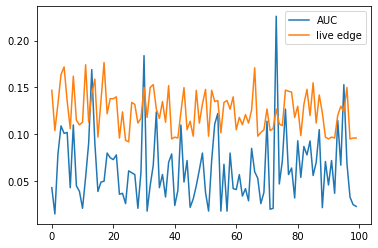

In [44]:
plt.figure()
plt.plot(auc_time_list,'-',label='AUC')
plt.plot(le_time_list,'-',label='live edge')
plt.legend()
plt.savefig('C:\\Users\\gaok\\PycharmProjects\\FINDER\\Result\\{}_{}_time_le_{}.jpg'.format(min_n,max_n,le_iter))
